# Backtester

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Stock Predictor Lib


In [2]:
import json as js
import numpy as np
import pandas as pd
from ta import *
#from fastai.structured import *
#from fastai.column_data import *


class StockPredictor:

    def __init__(self, df, index):
        self.df = df
        self.index = index

    # ///////////////////////////////
    # /////// DATA CLEANING /////////
    # ///////////////////////////////

    def sample_train(self, sampleSize):
        self.train = self.df.tail(sampleSize)
        print('Train size: ' + str(len(self.train)) +
              ' Original size: ' + str(len(self.df)))

    def set_date_as_index(self):
        self.train[self.index] = pd.to_datetime(self.train[self.index])

    def set_date_as_index_unix(self):
        self.train[self.index] = pd.to_datetime(
            self.train[self.index], unit='s')

    def split_train_validation(self, testRecordsCount, trainRecordsCount):
        self.test = self.train.tail(testRecordsCount)
        self.train = self.train.head(trainRecordsCount)
#        self.test.reset_index(inplace=True)
#        self.train.reset_index(inplace=True)
        print('Train size: ' + str(len(self.train)) +
              ' Test size: ' + str(len(self.test)))

    def normalize_train(self, volume, open, high, low, close):
        self.train = pd.DataFrame({
            'Timestamp': self.train[self.index],
            'Volume': self.train[volume],
            'Open': self.train[open],
            'High': self.train[high],
            'Low': self.train[low],
            'Close': self.train[close]
        })[['Timestamp', 'Volume', 'Open', 'High', 'Low', 'Close']]

    def clean_train(self):
        #     df = df.dropna()
        #     df = df.replace(np.nan,df.mean())
        self.train = self.train.replace([np.inf, -np.inf], np.nan)
        self.train = self.train.fillna(method='bfill')
        print('Train size: ' + str(len(self.train)))

    # ///////////////////////////////
    # //// FEATURE ENGINEERING //////
    # ///////////////////////////////

    def get_max_lookback(self, target, lookback):
        return self.train[target].rolling(
            window=lookback, min_periods=1).max()

    def add_ta(self):
        self.train = add_all_ta_features(
            self.train, "Open", "High", "Low", "Close", "Volume", fillna=True)
        self.train['max5'] = self.get_max_lookback("Close", 5)
        self.train['max15'] = self.get_max_lookback("Close", 15)
        self.train['max30'] = self.get_max_lookback("Close", 30)
        self.train['max60'] = self.get_max_lookback("Close", 60)
        self.train['max90'] = self.get_max_lookback("Close", 90)

    """ Set the target (dependent variable) by looking ahead in a certain time window and percent increase
        to determine if the action should be a BUY or a SELL. BUY is true/1 SELL is false/0"""

    def set_target(self, target, lookahead, percentIncrease):
        #        ,win_type='boxcar'
        max_in_lookahead_timeframe = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train['action'] = max_in_lookahead_timeframe > (
            percentIncrease * self.train['Close'])
#        self.train['max'] =max_in_lookahead_timeframe
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical(self, target, lookback, percentIncrease):
        max_in_lookback_timeframe = self.get_max_lookback(target, lookback)
        self.train['action'] = max_in_lookback_timeframe > (
            percentIncrease * self.train['Close'])
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical_hold(self, target, lookback, percentIncrease):
        self.train['action'] = 0
        max_lookback = self.get_max_lookback(target, lookback)
        self.train.loc[max_lookback > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookback > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    # ///////////////////////////////
    # ///////// EVALUATION //////////
    # ///////////////////////////////

    def generate_net_profit_result(self, df, startAmount, totalBuys, totalSells):
        startClose = df.Close.iloc[0]
        endClose = df.Close.iloc[-1]
        endBuyAmount = df.buyAmount.iloc[-1]
        endSellAmount = df.sellAmount.iloc[-1]
        endAmount = endBuyAmount if (
            endBuyAmount > 0) else (endSellAmount * endClose)
        buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
        percentIncrease = ((endAmount - startAmount)/startAmount) * 100
        percentDifference = percentIncrease - buyAndHoldPercentIncrease

        result = {
            'startClose': startClose,
            'endClose': endClose,
            'startAmount': startAmount,
            'endAmount': endAmount,
            'buyAndHoldPercentIncrease': round(buyAndHoldPercentIncrease, 3),
            'percentIncrease': round(percentIncrease, 3),
            'percentDifference': round(percentDifference, 3),
            'totalTrades': totalBuys + totalSells
        }
        return result

    def calculate_accuracy(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_buy_actions = df.loc[df.action == 1]
        total_sell_actions = df.loc[df.action == 0]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        sell_accuracy = (len(successful_sell_predictions) /
                         len(total_sell_actions))
        f1Score = (buy_accuracy + sell_accuracy)/2
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_net_profit(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 1 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount/row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 1 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount*row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' prevSellAmount: ' +
                    str(prevSellAmount) + ' prevBuyAmount: ' + str(prevBuyAmount))
        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 2 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 2 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            elif predicted == 1:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    # ///////////////////////////////
    # /////////// UTIL //////////////
    # ///////////////////////////////

    def save_to_feather(self):
        self.train.reset_index(inplace=True)
        self.train.to_feather(f'{PATH}train')

    def read_from_feather(self):
        self.train = pd.read_feather(f'{PATH}train')
        # train.drop(self.index,1,inplace=True)

    """ usage conflateTimeFrame(df, '5T') """

    def conflate_time_frame(self, df, timeFrame):
        ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
        return df.resample(timeFrame).agg(ohlc_dict)

    def plot_profit(self, df):
        df.plot(
            x='Timestamp',
            y=['Close', 'buyAmount'],
            style='o',
            figsize=(10, 5),
            grid=True)


In [3]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
        if right_on is None:
            right_on = left_on
        return left.merge(right, how='left', left_on=left_on, right_on=right_on,
                          suffixes=("", suffix))

## Config


In [4]:
np.set_printoptions(threshold=50, edgeitems=20)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
from IPython.display import HTML

In [5]:
lookahead = 10
sample_size=100000
percentIncrease = 1.002
# index='Timestamp'
index='time_period_start'
dep = 'action'
PATH='data/stock/'

## Create datasets

In [6]:
table_names = [
#         'btc-bitstamp-2012-01-01_to_2018-01-08'
#     'BTC_COINBASE_2018-07-25_09-06'
#     'ETH_COINBASE_07-21_08-24'
#     'COINBASE_BCH_2018-06-15_09-01'
#     'COINBASE_BTC_2017-11-01_01-09'
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27'
    'bitstamp_07-09'
]

In [7]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [8]:
for t in tables: display(t.head())

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2018-07-01T00:00:00.000Z,2018-07-01T00:01:00.000Z,2018-07-01T00:00:08.000Z,2018-07-01T00:00:59.000Z,6385.75,6396.08,6385.70,6392.09,2.891739,19
1,2018-07-01T00:01:00.000Z,2018-07-01T00:02:00.000Z,2018-07-01T00:01:15.000Z,2018-07-01T00:01:59.000Z,6387.16,6398.99,6385.09,6398.99,2.689349,13
2,2018-07-01T00:02:00.000Z,2018-07-01T00:03:00.000Z,2018-07-01T00:02:00.000Z,2018-07-01T00:02:46.000Z,6398.99,6420.57,6391.87,6408.14,29.993216,62
3,2018-07-01T00:03:00.000Z,2018-07-01T00:04:00.000Z,2018-07-01T00:03:02.000Z,2018-07-01T00:03:49.000Z,6414.99,6416.04,6397.12,6404.96,3.580496,18
4,2018-07-01T00:04:00.000Z,2018-07-01T00:05:00.000Z,2018-07-01T00:04:00.000Z,2018-07-01T00:04:59.000Z,6404.95,6411.84,6403.88,6408.03,2.502174,17


In [9]:
train= tables[0]

In [10]:
p = StockPredictor(train, index)
p.sample_train(sample_size)
# p.train = p.train.head(100000)

Train size: 100000 Original size: 100000


In [11]:
p.save_to_feather()

## Data Cleaning

In [12]:
p.read_from_feather()
p.set_date_as_index()
# p.set_date_as_index_unix()

In [13]:
# p.normalize_train('Volume_(BTC)','Open','High','Low','Close')
p.normalize_train('volume_traded','price_open','price_high','price_low','price_close')

## Conflate Time

In [14]:
# train = train.set_index(pd.DatetimeIndex(train[index]))
# p.train = p.conflate_time_frame(p.train, '5T')
# len(train)

## Set Target

In [15]:
p.set_target_historical('Close',lookahead, percentIncrease)
# p.set_target_historical_hold('Close',lookahead, percentIncrease)

Buy count: 19667 Sell count: 80333


In [16]:
# p.train.head(10)

In [17]:
# p.train.tail(10)

## Validation

In [18]:
valpred = pd.DataFrame({
    'Timestamp':p.train.Timestamp,
    'Close':p.train.Close,
    'action':p.train.action,
    'predicted':p.train.action
})[['Timestamp', 'Close', 'action', 'predicted']] 

In [19]:
# coinbaseDf= tables[1].tail(sample_size)
# coinbaseDf[index] = pd.to_datetime(coinbaseDf[index], unit='s')
# coinbaseExtract = pd.DataFrame({
#     'CoinbaseTimestamp':coinbaseDf.Timestamp,
#     'Close':coinbaseDf.Close,
# })[['CoinbaseTimestamp', 'Close']] 
# # valpred = bitstampExtract.join(coinbaseExtract)
# valpred = valpred.reset_index(drop=True)
# coinbaseExtract = coinbaseExtract.reset_index(drop=True)
# valpred = pd.concat([bitstampExtract, coinbaseExtract], axis=1)

In [20]:
p.calculate_net_profit(valpred, 1000, 0)
# p.calculate_net_profit_hold(valpred, 1000, 0)

{
    "startClose": 6392.09,
    "endClose": 6248.48,
    "startAmount": 1000,
    "endAmount": 4619.679170121502,
    "buyAndHoldPercentIncrease": -2.247,
    "percentIncrease": 361.968,
    "percentDifference": 364.215,
    "totalTrades": 10628
}


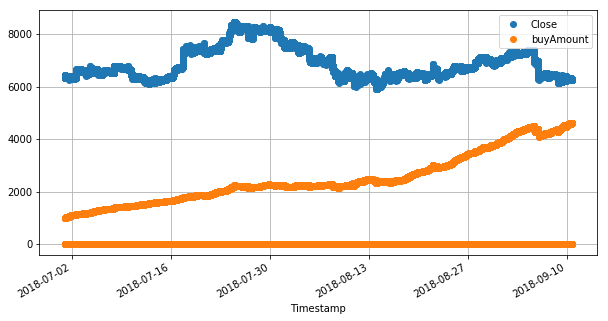

In [21]:
p.plot_profit(p.net_profit_df)
# train.tail(100)

In [22]:
# p.net_profit_df.head(10)

In [23]:
# p.net_profit_df.tail(10)